TP_learnable 모델이 어떠한 가중치를 갖고 있는지 확인용

In [1]:
# 사전 변수
checkpoint_dir = "/home/hschoi/data/leehyunwon/ECG-SNN/ver7/fordA/1_hidden_128/TP_learnable_2D_fordA_2025-05-05-23-28-47_fold1_lastEpoch.pt"
config_json_dir = "/home/hschoi/data/leehyunwon/ECG-SNN/ver7/fordA/1_hidden_128/TP_learnable_2D_fordA_2025-05-05-23-28-47_fold1_config.json"

savefile_name = "./result.svg" # 일단 미정



In [2]:
# Imports
import os
import torch
import numpy as np # .npy 읽기용
import pandas as pd # csv 읽기용
import torch.nn.functional as F  # 일부 활성화 함수 등 파라미터 없는 함수에 사용
import torchvision.datasets as datasets  # 일반적인 데이터셋; 이거 아마 MIT-BIH로 바꿔야 할 듯?
import torchvision.transforms as transforms  # 데이터 증강을 위한 일종의 변형작업이라 함
from torch import optim  # SGD, Adam 등의 옵티마이저(그래디언트는 이쪽으로 가면 됩니다)
from torch.optim.lr_scheduler import CosineAnnealingLR # 코사인스케줄러(옵티마이저 보조용)
from torch import nn  # 모든 DNN 모델들
from torch.utils.data import (DataLoader, Dataset)  # 미니배치 등의 데이터셋 관리를 도와주는 녀석
from tqdm import tqdm  # 진행도 표시용
import torchmetrics # 평가지표 로깅용
from typing import Callable # 람다식
from torch.utils.tensorboard import SummaryWriter # tensorboard 기록용
import time # 텐서보드 폴더명에 쓸 시각정보 기록용
import random # 랜덤시드 고정용

# 여긴 인코더 넣을때 혹시 몰라서 집어넣었음
import sys
import os
import json
import numpy as np

import argparse

# 얘는 SNN 학습이니까 당연히 있어야겠지? 특히 SNN 모델을 따로 만드려는 경우엔 뉴런 말고도 넣을 것이 많다.
# import spikingjelly.activation_based as jelly
from spikingjelly.activation_based import neuron, encoding, functional, surrogate, layer

from sklearn.model_selection import KFold # cross-validation용

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score

2025-06-01 23:47:12.594450: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-01 23:47:12.646693: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-01 23:47:13.429981: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# argparse 등의 config 분해용 코드
def load_json(path):
    with open(path) as data_file:
        param = json.load(data_file)

    return param

param = load_json(config_json_dir)
args = param

print(args)

{'config': '/home/hschoi/leehyunwon/ECG-SNN/new_server/ver7/IF/config/train/fordA/1_hidden_128/TP_learnable_config.json', 'device': {'gpu': '1', 'cuda': 'cuda'}, 'executor': {'type': 'trainer', 'args': {'random_seed': 999, 'k_folds': 5, 'num_epochs': 1000, 'early_stop_enable': False, 'early_stop_epoch': 25, 'optimizer': {'type': 'Adam', 'lr': 0.001}, 'scheduler': {'type': 'CosineAnnealingLR', 'args': {'T_max': 5, 'eta_min': 1e-05}}, 'checkpoint': {'active': True, 'path': '/home/hschoi/data/leehyunwon/ECG-SNN/ver7/fordA/1_hidden_128/'}}}, 'data_loader': {'type': 'fordA', 'args': {'batch_size': 256, 'num_workers': 8, 'train_path': '/home/hschoi/data/leehyunwon/time_series_FordA/FordA_TRAIN.ts', 'test_path': '/home/hschoi/data/leehyunwon/time_series_FordA/FordA_TEST.ts', 'dim': [1, 500]}}, 'model': {'type': 'TP_learnable_2D', 'args': {'type_args': {'encoder_min': 0.2, 'encoder_max': 2.0, 'encoder_learnable': True}, 'input_channel': 1, 'hidden_size': 1024, 'hidden_size_2': 128, 'num_classe

In [4]:
# cuda 환경 사용
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"  # GPU 번호별로 0번부터 나열
os.environ["CUDA_VISIBLE_DEVICES"]= str(args['device']['gpu'])  # 상황에 맞춰 변경할 것
device = "cuda" if torch.cuda.is_available() else "cpu" # 연산에 GPU 쓰도록 지정
print("Device :" + device) # 확인용

# 랜덤시드 고정
seed = args['executor']['args']['random_seed']
deterministic = True
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

Device :cuda


In [5]:
# TP_2D : 원래는 패키지에 따로 있지만 여기선 일단 따로 빼서 가져올 것
    ############################################ TP 방식, 2D ############################################
class TP_2D(nn.Module):
    def __init__(self, num_classes, input_channel, hidden_size, hidden_size_2, threshold_value, bias_option, reset_value_residual, encoder_min, encoder_max, device, encoder_learnable):
        super().__init__()
        
        # SNN 인코더 : 채널 크기만큼 확장하기
        self.encoder = nn.Sequential(
            # layer.Flatten(),
            layer.Linear(input_channel, hidden_size, bias=bias_option), # bias는 일단 기본값 True로 두기
            neuron.IFNode(surrogate_function=surrogate.ATan(),v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
            )

        # SNN 리니어 : 인코더 출력 -> 히든
        self.hidden = nn.Sequential(
            # layer.Flatten(),
            layer.Linear(hidden_size, hidden_size_2, bias=bias_option), # bias는 일단 기본값 True로 두기
            neuron.IFNode(surrogate_function=surrogate.ATan(),v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
            )
        

        # SNN 리니어 : 히든 -> 출력
        self.layer = nn.Sequential(
            # layer.Flatten(),
            layer.Linear(hidden_size_2, num_classes, bias=bias_option), # bias는 일단 기본값 True로 두기
            neuron.IFNode(surrogate_function=surrogate.ATan(),v_reset= None if reset_value_residual else 0.0, v_threshold=threshold_value),
            )


        # 인코더 가중치 수동지정
        manual_weights = torch.linspace(encoder_min,encoder_max,steps=hidden_size).view(1,-1).to(device).transpose(1,0) # 0.2부터 2.0까지 인코더 뉴런 수만큼 지정
        manual_weights = manual_weights.expand(-1, input_channel).clone()  # shape 확장 필요 : (hidden_size, 채널) 크기가 되도록 지정
        self.encoder[0].weight = nn.Parameter(manual_weights) # 대입
        self.encoder[0].bias.data.fill_(0.0) # bias도 0으로 초기화

        # 인코더 가중치 학습여부는 TP냐 TP_learnable이냐 따라 다름!
        for param in self.encoder.parameters():
            param.requires_grad = encoder_learnable


    def forward(self, x: torch.Tensor):
        results = 0. # for문이 모델 안에 있으므로 밖에다가는 이녀석을 내보내야 함
        # print(x.shape) # (배치크기, 채널(61, 6 등), 시간축(405, 500 등등) 모양이 될 것
        
        timestep_size = x.shape[2] # 405 timestep을 만들어야 함
        # 근데 이제 이렇게 바꾼 데이터는 (배치, 출력크기) 만큼의 값을 갖고 있으니 여기서 나온 값들을 하나씩 잘라서 다음 레이어로 넘겨야 한다.
        for i in range(timestep_size) : 
            x_slice = x[:,:,i] # 슬라이스 진행 후 256, 61 등의 크기가 되도록 shape 수정(squeeze 등은 여기서 필요없음)
            x_slice = self.encoder(x_slice)
            x_slice = self.hidden(x_slice)
            x_slice = self.layer(x_slice)
            results += x_slice  # 결과를 리스트에 저장(출력발화값은 전부 더하는 식으로)
        # results = torch.stack(results, dim=0) # 텐서로 바꾸기
        return results / timestep_size

In [6]:
# 모델 불러다가 .pt에 맞춰서 넣기 : 일단 FordA 데이터셋으로 학습된 모델을 쓰지만, 데이터로더는 여기선 필요없음

# 임시 : args 변경
args_original = args
args = args['model']

# SNN 네트워크 초기화
model = TP_2D(num_classes = args['args']['num_classes'], input_channel=args['args']['input_channel'],
                        hidden_size=args['args']['hidden_size'], hidden_size_2=args['args']['hidden_size_2'], 
                        threshold_value=args['args']['threshold'], bias_option=args['args']['need_bias'], 
                        reset_value_residual=args['args']['reset_value_residual'], 
                        encoder_min = args['args']['type_args']['encoder_min'], encoder_max = args['args']['type_args']['encoder_max'], 
                        device = device, encoder_learnable=args['args']['type_args']['encoder_learnable']).to(device=device)

# args 원복
args = args_original

# 모델 로드 함수 정의
def load_model(checkpoint_path_, model):
    checkpoint = torch.load(checkpoint_path_)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()  # 평가 모드로 전환
    return model


# 모델에 가중치 넣기
model = load_model(checkpoint_dir, model)

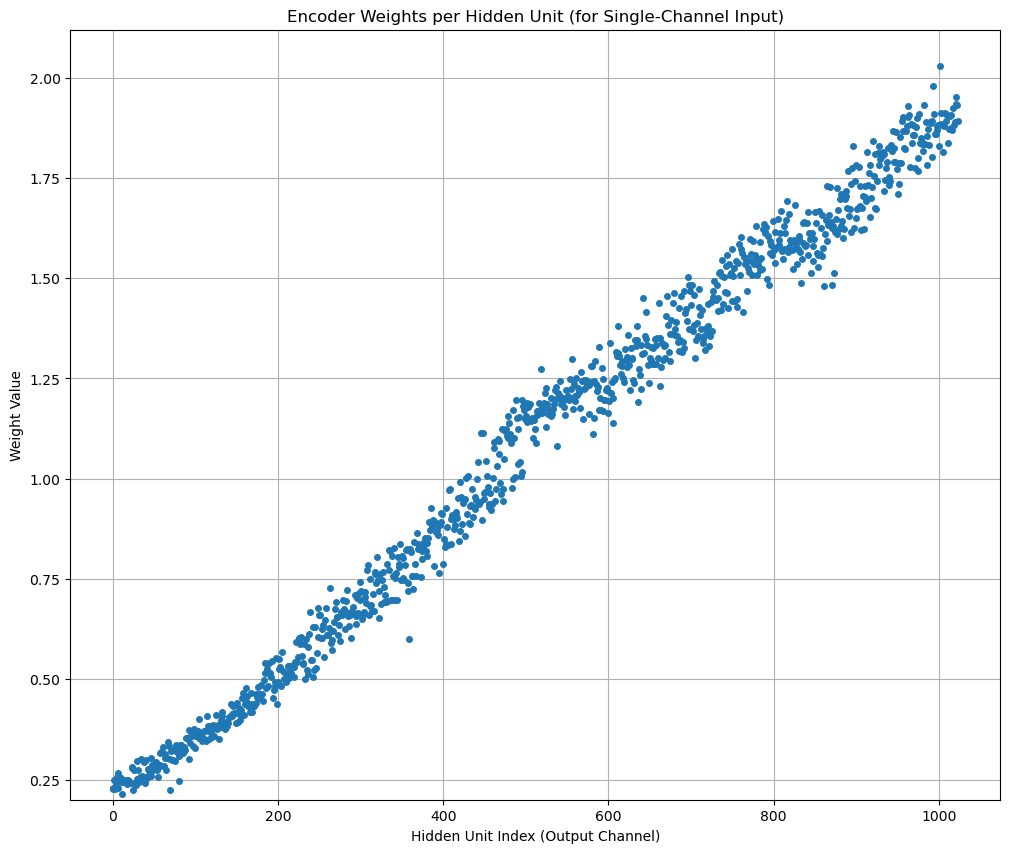

In [9]:
# encoder 가중치 불러오기
weights = model.encoder[0].weight.detach().cpu().numpy()

# 입력 채널이 1개일 경우, shape: (hidden_size, 1) -> flatten
if weights.shape[1] == 1:
    weights = weights.squeeze(1)

# x축: Hidden Unit 인덱스 (출력 채널)
x = range(len(weights))

# Plot 그리기
plt.figure(figsize=(12, 10))
plt.plot(x, weights, marker='o', markersize=4, linestyle='None')  # 점 크기를 4로 설정
plt.ylim(0.2, None)  # y축 범위 설정 (0.2부터 시작)
plt.xlabel('Hidden Unit Index (Output Channel)')
plt.ylabel('Weight Value')
plt.title('Encoder Weights per Hidden Unit (for Single-Channel Input)')
plt.grid(True)

plt.savefig(savefile_name, format="svg", bbox_inches="tight")
plt.show()
plt.close()